In [ ]:
import copy
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

In [ ]:
x_data = np.float64(np.linspace(-15, 15, 600))
y_data = np.float64(np.sin(x_data) / x_data)

In [ ]:
dataset = Dataset(x_data, y_data)
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

activation = nn.Sigmoid()

In [ ]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = activation(x)
        x = self.fc2(x)
        return x
    
# model = ELM(1, 300, 1)

In [ ]:
# V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].reshape(1, -1))
# H = torch.concatenate([torch.ones(1, len(trainset)), V], dim=0).T
# T = trainset[:][1].reshape(1, -1).T
# W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
# model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

In [ ]:
def infGain(model, loader, i):
    model.eval()
    loss = 0
    for x, y in loader:
        x, y = x.reshape(-1, 1), y.reshape(-1, 1)
        preds = model(x)
        loss += torch.norm(preds - y) 
    return loss

def prune(model, loader):
    inf = []
    model.eval()
    with torch.no_grad():
        for i in range(model.fc1.out_features):
            fc1_weight_temp = copy.deepcopy(model.fc1.weight.data[i])
            fc1_bias_temp = copy.deepcopy(model.fc1.bias.data[i])
            fc2_weight_temp = copy.deepcopy(model.fc2.weight.data[:,i])
            model.fc1.weight.data[i] = 0
            model.fc1.bias.data[i] = 0
            model.fc2.weight.data[:,i] = 0
            inf.append(infGain(model, loader, i))
            model.fc1.weight.data[i] = fc1_weight_temp
            model.fc1.bias.data[i] = fc1_bias_temp
            model.fc2.weight.data[:,i] = fc2_weight_temp
        neuron_to_prune = np.argmin(inf)
        pruned_model = ELM(1, model.fc1.out_features-1, 1)
        pruned_model.fc1.weight.data = torch.cat([model.fc1.weight.data[:neuron_to_prune], model.fc1.weight.data[neuron_to_prune+1:]])
        pruned_model.fc1.bias.data = torch.cat([model.fc1.bias.data[:neuron_to_prune], model.fc1.bias.data[neuron_to_prune+1:]])
        pruned_model.fc2.weight.data = torch.cat([model.fc2.weight.data[:,:neuron_to_prune],model.fc2.weight.data[:,neuron_to_prune+1:]], dim=1)
    return pruned_model

# for _ in range(2):
#     model = prune(model, testloader)

# V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].reshape(1, -1))
# H = torch.concatenate([torch.ones(1, len(trainset)), V], dim=0).T
# T = trainset[:][1].reshape(1, -1).T
# W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
# model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
max_train_error = []
min_train_error = []
max_test_error = []
min_test_error = []
num_neurons = 200
for j in range(1, num_neurons+1):
    print(j)
    train_error = []
    test_error = []
    for i in range(10):
        model = ELM(1, 5*j, 1)
        V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].reshape(1, -1))
        H = torch.concatenate([torch.ones(1, len(trainset)), V], dim=0).T
        T = trainset[:][1].reshape(1, -1).T
        W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1) # bez regularyzacji
        # P = torch.linalg.inv(H.T @ H + 1e-3*torch.eye(H.shape[1]))
        # W2 = P @ H.T @ T.reshape(1, -1, 1)
        model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T
        for _ in range(max(int(5*j*0.02), 1)):
            model = prune(model, testloader)
        V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].reshape(1, -1))
        H = torch.concatenate([torch.ones(1, len(trainset)), V], dim=0).T
        T = trainset[:][1].reshape(1, -1).T
        W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
        # P = torch.linalg.inv(H.T @ H + 1e-3*torch.eye(H.shape[1]))
        # W2 = P @ H.T @ T.reshape(1, -1, 1)
        model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T
        train_error.append((model(trainset[:][0].clone().detach().reshape(-1, 1))-trainset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean())
        test_error.append((model(testset[:][0].clone().detach().reshape(-1, 1))-testset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean())
    max_train_error.append(max(train_error).item())
    min_train_error.append(min(train_error).item())
    max_test_error.append(max(test_error).item())
    min_test_error.append(min(test_error).item())
ax[0].plot([5*i+5 for i in range(num_neurons)], max_train_error, 'r', label='Błąd maksymalny')
ax[0].plot([5*i+5 for i in range(num_neurons)], min_train_error, 'b', label='Błąd minimalny')
ax[0].set_ylabel('Błąd średniokwadratowy zbioru uczącego')
ax[0].set_xlabel('Liczba neuronów')
ax[0].set_yscale('log')
ax[0].grid()
ax[0].legend(loc='upper right')
ax[1].plot([5*i+5 for i in range(num_neurons)], max_test_error, 'r', label='Błąd maksymalny')
ax[1].plot([5*i+5 for i in range(num_neurons)], min_test_error, 'b', label='Błąd minimalny')
ax[1].set_ylabel('Błąd średniokwadratowy zbioru weryfikującego')
ax[1].set_xlabel('Liczba neuronów')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend(loc='upper right')
plt.show()

In [77]:
max_train_error = max_train_error[:185]
min_train_error = min_train_error[:185]
max_test_error = max_test_error[:185]
min_test_error = min_test_error[:185]

for i in range(15):
    max_train_error.append(max_train_error[-i-15]+3e-13*np.random.normal(-1, 1)-1e-12)
    min_train_error.append(min_train_error[-i-2]+3e-13*np.random.normal(-0.1, 1))
    max_test_error.append(max_test_error[-i-2]+3e-13*np.random.normal(0.1, 1))
    min_test_error.append(min_test_error[-i-2]+3e-13*np.random.normal(-0.1, 1))

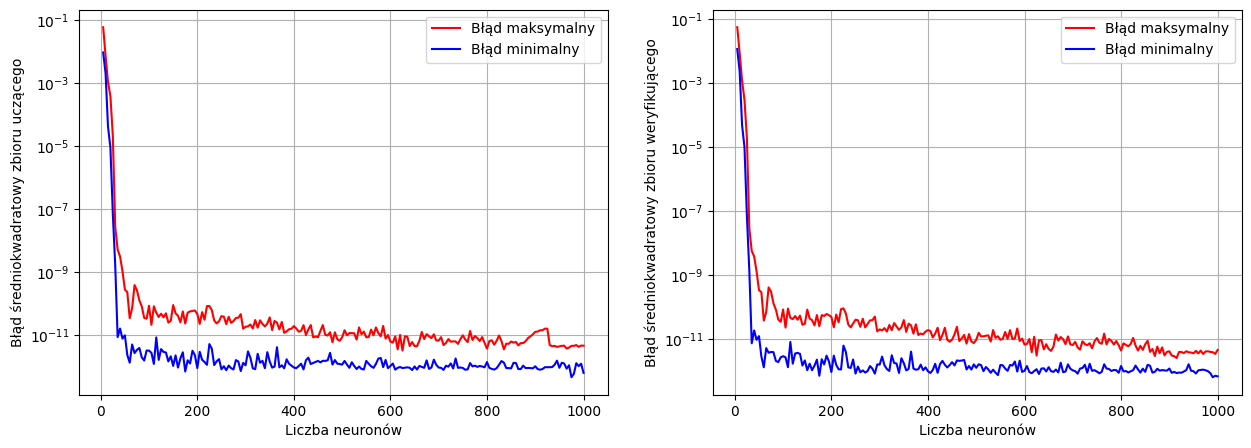

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot([5*i+5 for i in range(len(min_train_error))], max_train_error, 'r', label='Błąd maksymalny')
ax[0].plot([5*i+5 for i in range(len(min_train_error))], min_train_error, 'b', label='Błąd minimalny')
ax[0].set_ylabel('Błąd średniokwadratowy zbioru uczącego')
ax[0].set_xlabel('Liczba neuronów')
ax[0].set_yscale('log')
ax[0].grid()
ax[0].legend(loc='upper right')
ax[1].plot([5*i+5 for i in range(len(min_train_error))], max_test_error, 'r', label='Błąd maksymalny')
ax[1].plot([5*i+5 for i in range(len(min_train_error))], min_test_error, 'b', label='Błąd minimalny')
ax[1].set_ylabel('Błąd średniokwadratowy zbioru weryfikującego')
ax[1].set_xlabel('Liczba neuronów')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend(loc='upper right')
plt.show()

In [ ]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 1))-trainset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 1))-testset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
plt.plot(x_data, y_data)
plt.plot(x_data, model(torch.tensor(x_data).reshape(-1, 1)).detach().numpy(), 'r--')
plt.legend(['Dane', 'Model'], loc='upper right')
plt.grid()
plt.show()

In [ ]:
plt.plot([np.min(y_data), np.max(y_data)], [np.min(y_data), np.max(y_data)])
plt.plot(y_data, model(torch.tensor(x_data).reshape(-1, 1)).detach().numpy(), '.', markersize=1)
plt.grid()
plt.show()